# NSCool interactive notebook - Terzan 5 X-2

An interactive Python interface to the NSCool code with an incoorporated fitting routine. This notebook for the analysis of the cooling crust of the Terzan 5 X-2 source after an accretion outburst shows how to use the fitting routine 'interactively'.

#### Import packages, NSCool code and read temperature data

In [1]:
%run 'anim_to_html.ipynb'
%pylab inline
import NSCool_Py
import Boundary_Py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
import scipy.optimize as optimize
import scipy.interpolate
import os

# For inline interactive plot:
# %matplotlib notebook

fsize=15

# Read crust cooling temperature data
import Read_Data
data_time, data_Teff, data_dT1 , data_dT2 = Read_Data.Terzan5_X2() # KS_1731_260()
data_Ltime = np.log(data_time)/np.log(10.)

print data_time
print data_Teff

# Constants
eV    = 1.16044e4
day   = 86400.
year  = 365.25 * 864002
t_pre_outburst = 20 * 365.25

Populating the interactive namespace from numpy and matplotlib
[   53.    124.5   254.5   504.    631.5   672.    784.    932.   1297. ]
[ 99.7  91.5  89.2  84.8  88.5  84.6  82.8  85.4  82.7]


#### Initialize NSCool

In [2]:
# Use this filename for regular use
# filename0  = 'Cool_APR-1.4_Acc-Dany-08_Choose-0-0_Mdot=0.2Edd_7.5_Termo=200keV_aTD=0_Q3zones.in'
# Use this filename for fit use
filename0 = 'Cool_Accretion_TerzanX2.in'
directory0 = 'Ter5_X-2'
directory = 'Models/' + directory0
filename = directory + '/' + filename0          # Control file
filefit = directory + '/fit_input.dat'          # Name of fit input file with initial parameter guesses
                                                # these parameters + fit control can also be overwritten from the notebook.
                                                # See below for an example.
print filename
print filefit

MODE = 'PYTO'
ip_max = 1
chi2 = 0.

# Start NSCool
NSCool_Py.nscool_start(filename,filename0,directory,directory0,MODE,ip_max,chi2)

# Initialize fit and read in fit input
NSCool_Py.nscool_fit_init(filename,filename0,directory,directory0,MODE,filefit,0.0)

Models/Ter5_X-2/Cool_Accretion_TerzanX2.in
Models/Ter5_X-2/fit_input.dat


#### Set (fit) neutron star parameters (default from fit_input file or change below)

In [3]:
# Set neutron star parameters (initial guesses for fit)
ns_mass = NSCool_Py.fit_param.emas_new_d
ns_radius = NSCool_Py.fit_param.rad_new_d
ns_Tcore = NSCool_Py.fit_param.temp_core  # 4.72e+07 # 
ns_yenv = NSCool_Py.fit_param.yenv_d
ns_qshallow = NSCool_Py.fit_param.q_nd
ns_rhoshallow = NSCool_Py.fit_param.rho_nd
ns_Qimp1 = NSCool_Py.fit_param.q_imp_z1
ns_Qimp2 = NSCool_Py.fit_param.q_imp_z2

# Print neutron star parameters
print 'Neutron star parameters'
print '-------------------------------'
print("{0: <13} {1: <5} {2:.2f} ".format('Mass ', '=', float(ns_mass)))
print("{0: <13} {1: <5} {2:.2e} ".format('Radius ', '=', float(ns_radius)))
print("{0: <13} {1: <5} {2:.2e} ".format('Tcore ', '=', float(ns_Tcore)))
print("{0: <13} {1: <5} {2:.2e} ".format('Yenv ', '=', float(ns_yenv)))
print("{0: <13} {1: <5} {2:.0f} ".format('Qshallow ', '=', float(ns_qshallow)))
print("{0: <13} {1: <5} {2:.2e} ".format('rho shallow ', '=', float(ns_rhoshallow)))
print("{0: <13} {1: <5} {2:.2f} ".format('Qimp1 ', '=', float(ns_Qimp1)))
print("{0: <13} {1: <5} {2:.2f} ".format('Qimp2 ', '=', float(ns_Qimp2)))

Neutron star parameters
-------------------------------
Mass          =     1.40 
Radius        =     1.00e+06 
Tcore         =     6.70e+07 
Yenv          =     6.60e+07 
Qshallow      =     2800 
rho shallow   =     7.00e+09 
Qimp1         =     350.00 
Qimp2         =     10.00 


#### Run NSCool once with these parameters for inspection


In [4]:
# Run NSCool with these parameters
# NSCool_Py.impurity_t.q_imp_t[2] = 2.0     # Currently using 3 zones for Qimp, but only fitting 2. 
NSCool_Py.nscool_function(ns_yenv,ns_radius,ns_mass,ns_Tcore,ns_qshallow,ns_rhoshallow,ns_Qimp1,ns_Qimp2)

#### Plot the resulting cooling curve

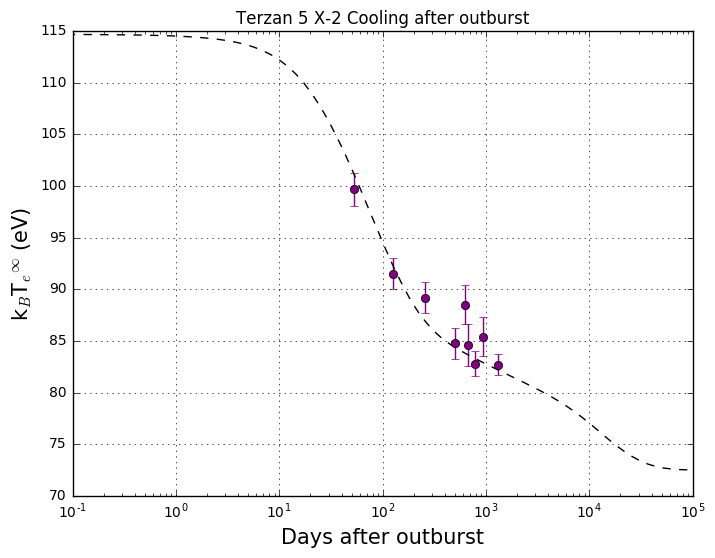

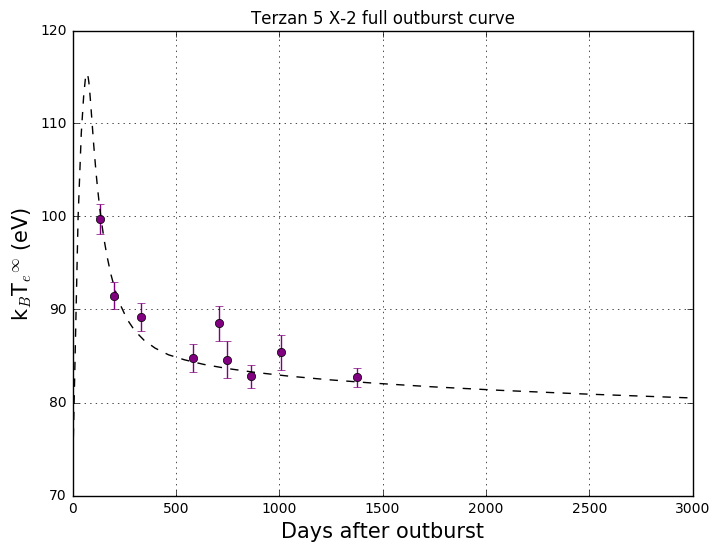

In [5]:
# Time indices take values from 0 to jmax-1:
jmax = NSCool_Py.results.istep_max

# 1D time dependent arrays:
# j takes jmax values: 0, ..., jmax-1
Age0  = NSCool_Py.accretion.t_acc0 + NSCool_Py.accretion.t_acc2[0]
Age0  = Age0/day

Age   = NSCool_Py.results.age[0:jmax]/day
LAge  = np.log(Age)/np.log(10.)
Teff  = NSCool_Py.results.teff[0:jmax]/eV

# Age1 and Teff1 is the data after outburst
Teff1 = Teff[np.where(Age > Age0)]
Age1 = Age[np.where(Age > Age0)] - Age0


# Plot cooling curve after the outburst has ended (log x-scale)
Read_Data.plot_NSCool(Age1, Teff1, data_time=data_time, data_teff=data_Teff, yerr=[data_dT1, data_dT2],
                      x_lim=[0.1, 1e5], xlog=True, title='Terzan 5 X-2 Cooling after outburst')


# Plot full outburst with subsequent cooling (linear x-scale)
Read_Data.plot_NSCool(Age - t_pre_outburst, Teff, data_time=(data_time+Age0-t_pre_outburst), 
                      data_teff=data_Teff, yerr=[data_dT1, data_dT2], x_lim=[0,3000],
                      title='Terzan 5 X-2 full outburst curve')

#### Control fit options

This section is optional. The options are also set in the <i>fit_input</i> file, but can be controlled interactively from the notebook if desired.

In [14]:
##
##    THIS PART IS OPTIONAL
##

# Fit control options
NSCool_Py.fit_control.run_type = 0                  # Run type: 0 = fit, 1 = fit + errorbars, 2 = parameter space study
NSCool_Py.fit_control.chlimit = 0.01                # Minimum chi2 change to continue fit 
NSCool_Py.fit_control.max_step = 100                # Maxstep: controls maximum nr of times fit enters

# Fit output options
NSCool_Py.fit_control.intermediate_save = 0         # Convergence data (=1 for save chi2 at each iteration, =0 for none)
                                                    # This data can be used to study the convergence of the fit routine


#### Run the fit 

Start the fitting. You can keep control of the fit progress in the seperate cmd window that has opened after running nscool_start. 

In [12]:
NSCool_Py.nscool_runfit()
print 'Fit is done!'

ns_mass = NSCool_Py.fit_param.emas_new_d
ns_radius = NSCool_Py.fit_param.rad_new_d
ns_Tcore = NSCool_Py.fit_param.temp_core  # 4.72e+07 # 
ns_yenv = NSCool_Py.fit_param.yenv_d
ns_qshallow = NSCool_Py.fit_param.q_nd
ns_rhoshallow = NSCool_Py.fit_param.rho_nd
ns_Qimp1 = NSCool_Py.fit_param.q_imp_z1
ns_Qimp2 = NSCool_Py.fit_param.q_imp_z2

print 'Neutron star best fit parameters'
print '-------------------------------'
print("{0: <13} {1: <5} {2:.2f} ".format('Mass ', '=', float(ns_mass)))
print("{0: <13} {1: <5} {2:.2e} ".format('Radius ', '=', float(ns_radius)))
print("{0: <13} {1: <5} {2:.2e} ".format('Tcore ', '=', float(ns_Tcore)))
print("{0: <13} {1: <5} {2:.2e} ".format('Yenv ', '=', float(ns_yenv)))
print("{0: <13} {1: <5} {2:.0f} ".format('Qshallow ', '=', float(ns_qshallow)))
print("{0: <13} {1: <5} {2:.2e} ".format('rho shallow ', '=', float(ns_rhoshallow)))
print("{0: <13} {1: <5} {2:.2f} ".format('Qimp1 ', '=', float(ns_Qimp1)))
print("{0: <13} {1: <5} {2:.2f} ".format('Qimp2 ', '=', float(ns_Qimp2)))
print '-------------------------------'
print("{0: <13} {1: <5} {2:.2f} ".format('Chi^2 ', '=', float(NSCool_Py.iterations.pychi2))) 


Fit is done!
Neutron star best fit parameters
-------------------------------
Mass          =     1.40 
Radius        =     1.00e+06 
Tcore         =     9.72e+07 
Yenv          =     9.82e+06 
Qshallow      =     1784 
rho shallow   =     3.43e+09 
Qimp1         =     0.01 
Qimp2         =     6.99 
-------------------------------
Chi^2         =     8.26 


## Inspect crust properties

#### Impurity factor (now using a stepfunction)

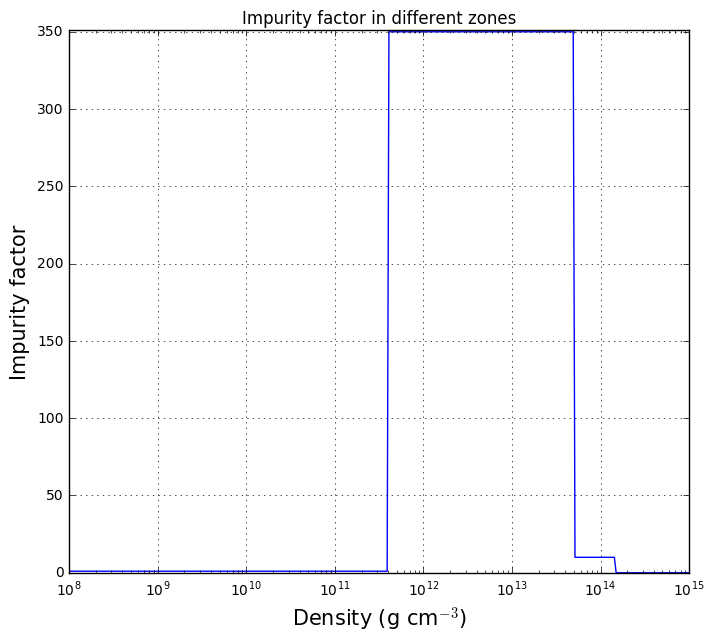

In [6]:
fig = plt.figure(figsize=(8,7))
plt.plot(NSCool_Py.profile_star.rrho, NSCool_Py.profile_comp.q_imp)
plt.xscale('log')
plt.ylim(0, np.max(NSCool_Py.profile_comp.q_imp)+1)
plt.xlabel('Density (g cm$^{-3}$)', fontsize=15)
plt.ylabel('Impurity factor', fontsize=15)
plt.title('Impurity factor in different zones')
plt.grid(True)
plt.show()

#### Make movie of temperature in NS

If pmovie = 2 (in <i>I.dat</i> file or by setting NSCool_Py..pmovie before running the function above) then the movie files are saved to the folder <i>TMP_Movie</i>. Below these files are read and converted to a movie. For interactive display or for saving as a video/gif.

In [7]:
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [8]:
# from matplotlib import animation, rc
# from IPython.display import HTML
# import matplotlib
# matplotlib.rc('font',**{'family':'serif','sans-serif':['Avant Garde'],'size': 12})
movie_fsize=12
# Read in movie data
movie_files = [] 
for file in os.listdir('./TMP_Movie/'):
    if file.endswith('.dat'):
        movie_files.append(file)

data = np.genfromtxt('./TMP_Movie/'+movie_files[0])
meltrho = data[:,10]
meltT= np.log(data[:,-3][0])
print meltT

# Setup the figure layout for movie
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# AX1
ax1.set_xlabel('Days since beginning outburst', fontsize=movie_fsize)
ax1.set_ylabel('k$_B$T${_{e}}^{\infty}$ (eV)', fontsize=movie_fsize)
ax1.plot(Age - t_pre_outburst, Teff)
# ax1.plot(current_time, current_temp, marker='o', markersize=10)
ax1.set_xlim(-50,5000)

# Intialize drawn objects
point, = ax1.plot([], [], marker='v', markersize=10., c='r')

# Ax2
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_xlim(10**8.,10**15.)
ax2.set_ylim(7.95,8.4)

ax2.set_xlabel('Density (g cm$^{-3}$)', fontsize=movie_fsize)
ax2.set_ylabel('log(T) (K)', fontsize=movie_fsize)


# Intialize drawn objects
line, = ax2.plot([], [], lw=1)

time = ax2.text(11**12, 8.35, 'time = -1 yr', fontsize=movie_fsize)

# Setup the first frame (shown before play)
def init():
    data = np.genfromtxt('./TMP_Movie/'+movie_files[0])
    rho = 10**(data[:,5])
    T = (data[:, 4])
   
    current_time = data[:,0][0]*365.25 + abs(t_pre_outburst - Age0)
    current_temp = data[:,1][0]
    
    LogTc_n_pg= 10**data[:,-3]
    LogTc_p_pg = 10**data[:,-2]
    LogT_M_pg = 10**data[:,-2]
    
    point.set_data(current_time, current_temp)
    
    line.set_data(rho, T)
    time.set_text('time = -1 yr')
    return line, time, point

# Animation function is called sequentially
def animate(i):

    data = np.genfromtxt('./TMP_Movie/'+movie_files[i])
    rho = 10**(data[:,5])
    T = (data[:, 4])
    t = data[:, 0][0]
    current_time = data[:,0][0]*365.25 + abs(t_pre_outburst - Age0)
    current_temp = data[:,1][0]

    point.set_data(current_time, current_temp)   
    line.set_data(rho, T)   
    time.set_text('t = '+'{0:.3f}'.format(t)+' yr')
    
    return line, time, point

# Call the animator. blit=True means only re-draw the parts that have changed.

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(movie_files), interval=50, blit=True)
# anim._encoded_video = 'video/mp4;base64,' + video.encode("base64")

display_animation(anim)
# HTML(anim.to_html5_video())
 

/net/glados2.science.uva.nl/api/10247025/poppetje/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


-inf


## Convergence of the fitting routine

Plot the Chi2 evolution

Ter5_X2_temp_v2


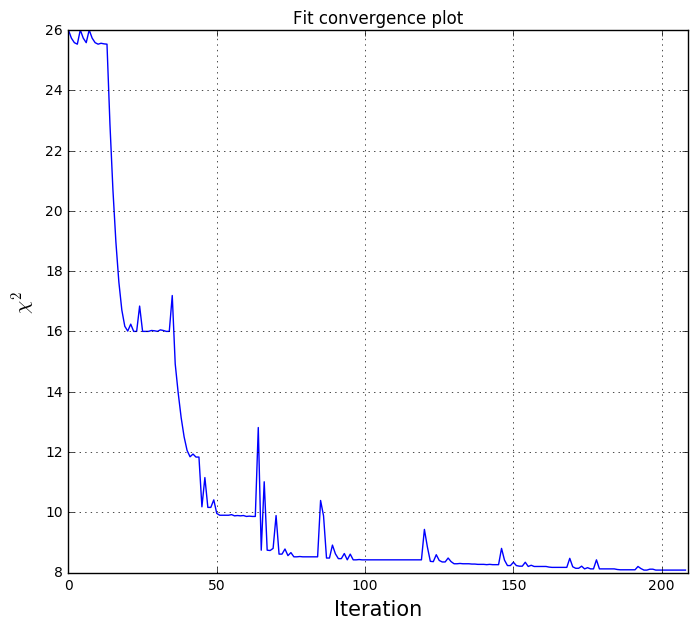

In [9]:
fit_id = ''.join(NSCool_Py.fit_control.fit_id).strip()
print fit_id
chi2_data = np.genfromtxt('Ter5_X2_convergence.dat')

fig = plt.figure(figsize=(8,7))
plt.plot(range(0,len(chi2_data)), chi2_data)
plt.xlabel('Iteration', fontsize=fsize)
plt.ylabel(r'$\chi^2$', fontsize=fsize)
plt.title('Fit convergence plot')
plt.xlim(0,len(chi2_data))
plt.grid(True)
plt.show()

## Contour plots

In [9]:
# Declare some functions for file reading and contourplots

def plot_contour(data, xlabel, ylabel, plot_boundary=False, title='MXB 1659-29 Crust Parameters'):
    '''
    Takes 3D data array. First 2 columns are parameters, 
    last column in chi squared values.
    '''
    p1, p2, chi2_d = data[:,0], data[:,1], data[:,2]

    # x, y = np.meshgrid(p1, p2)

    # Set up a regular grid of interpolation points
    xi, yi = np.linspace(p1.min(),p1.max(), 1500), np.linspace(p2.min(), p2.max(), 1500)
    xi, yi = np.meshgrid(xi, yi)


    # Interpolate
    zi = scipy.interpolate.griddata((p1, p2), chi2_d, (xi, yi), method='linear')
 

    print data[np.argmin(data[:, 2])]

    plt.figure(figsize=(10,8))
    CS = plt.contour(xi, yi, zi, levels=[np.min(chi2_d)+1, np.min(chi2_d)+2, np.min(chi2_d)+3],
     colors='k', linestyles=['-', '--', '-.'])
    CS.levels = ['1 $\sigma$', '2 $\sigma$', '3 $\sigma$']
    plt.clabel(CS, CS.levels, fontsize=15, inline=1)
    plt.title(title, fontsize=15)
    plt.ylabel(xlabel, fontsize=20)
    plt.xlabel(ylabel, fontsize=20)
    plt.grid(True)
    plt.xlim(1500,2000)
    plt.ylim(2e9,4e9)
    plt.show()

    plt.figure(figsize=(10,8))
#     cmap = matplotlib.cm.jet
#     cmap_r = reverse_colourmap(cmap)
    plt.pcolormesh(xi, yi, zi, vmin=np.min(chi2_d), vmax=15, cmap=plt.get_cmap('jet_r'))      # , cmap=plt.get_cmap('RdYlGn')
    plt.colorbar() 
    plt.title(title, fontsize=15)
    plt.ylabel(xlabel, fontsize=20)
    plt.xlabel(ylabel, fontsize=20)
#     plt.yscale('log')
    plt.xlim(np.min(xi),np.max(xi))
    plt.ylim(np.min(yi),np.max(yi))
    
    if plot_boundary:
        plt.axhline(y=1e8, linestyle='--', c='y', linewidth=5)
        
    plt.xlim(1500,2000)
    plt.ylim(2e9,4e9)
#     plt.grid(True)
    plt.show()
    

    return

[  2.08400000e+03   7.92999834e+09   7.79000000e+00]


<IPython.core.display.Javascript object>


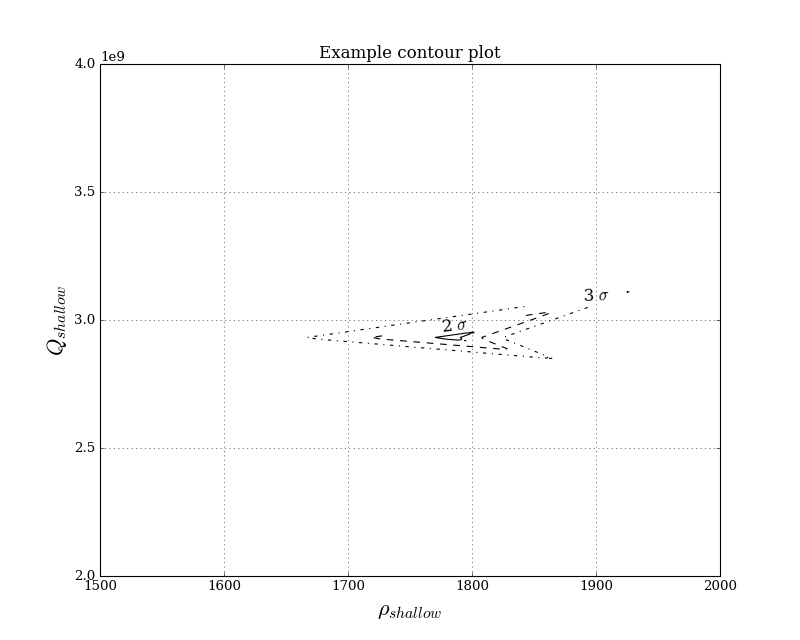

<IPython.core.display.Javascript object>


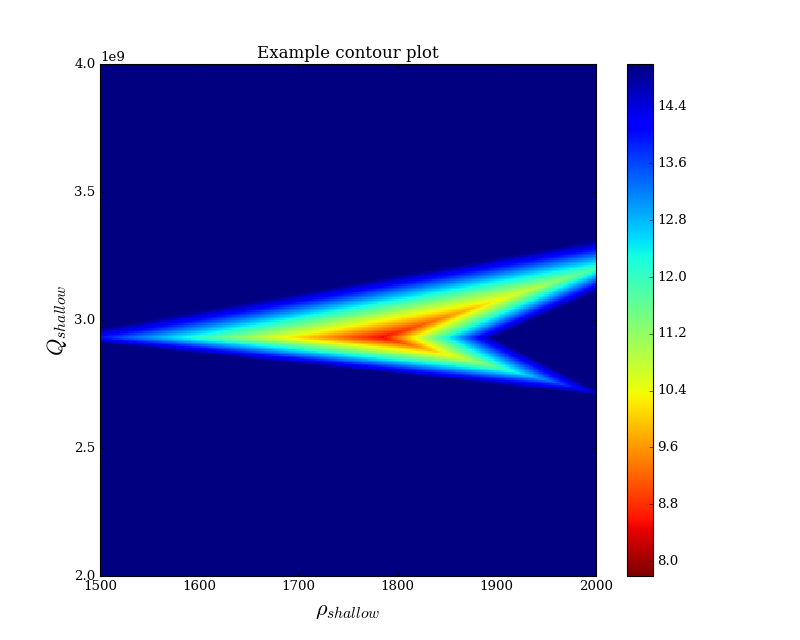

In [10]:
# import scipy.interpolate
parameter_file = directory+'/Output/Ter5_X2_Qshallow_rho.dat'
data = np.genfromtxt(parameter_file)
plot_contour(data, r'$Q_{shallow}}$', r'$\rho_{shallow}$', title='Example contour plot')         #    (MeV/nucleon)}$')

In [14]:
plt.plot(NSCool_Py.profile_star.rrho, NSCool_Py.profile_star.e2phi)
plt.plot(NSCool_Py.profile_star.rrho, NSCool_Py.profile_star.rad)
plt.show()

In [15]:
# To use the new envelope
print '---------- Envelope:'
NSCool_Py.bound_param.ifteff  = 0
Log_yHe = 1.
Log_yC  = 3.
NSCool_Py.bound_param.log_yhe = Log_yHe
NSCool_Py.bound_param.log_yc  = Log_yC
NSCool_Py.bound_param.yhe     = 10.**Log_yHe
NSCool_Py.bound_param.yc      = 10.**Log_yC

print NSCool_Py.bound_param.ifteff
print NSCool_Py.bound_param.log_yhe
print NSCool_Py.bound_param.log_yc

---------- Envelope:
0
1.0
3.0


In [13]:
help(Read_Data.plot_NSCool)

Help on function plot_NSCool in module Read_Data:

plot_NSCool(time, teff, data_time=[], data_teff=[], yerr=[], y_lim=[], x_lim=[], xlog=False, ylog=False, title='')
    Plot the cooling curve
    
    Required arguments:
    time -- 1D array or list with age to be plotted on x-axis
    teff -- 1D array or list with temperatures to be plotted on y-axis
    
    Optional arguments:
    data_time -- ages for observed temperature data temperatures (1D array)
    data_teff -- observed temperature data temperatures (1D array)
    yerr -- list with assymetric temperature data errors (1D array) or 
            single value (float)
    y_lim -- y axis plot limits [lowerlimit, upperlimit]
    x_lim -- x axis plot limits [lowerlimit, upperlimit]
    xlog -- logaritmic scale x axis if True
    ylog -- logaritmic scale y axis if True
    title -- plot title (string)

